In [13]:
# Figure 1

In [14]:
import re
import warnings

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmaps
import matplotlib as mpl
import matplotlib.pyplot as plt
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from gcpy import single_panel
from matplotlib.gridspec import GridSpec
import numpy as np
import regionmask
import scipy.stats as stats
from scipy.stats import gmean, gstd
import seaborn as sns
import xarray as xr

from src import tools

warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# Load observations: June 
months = [6,6,6]
daily_mda8o3_ar6_ena = tools.get_observed_daily_mda8o3_ar6_afternoon("ENA", months[0], criteria=90, min_hour='12:00', max_hour='17:00')
daily_mda8o3_ar6_wce = tools.get_observed_daily_mda8o3_ar6_afternoon("WCE", months[1], criteria=90, min_hour='12:00', max_hour='17:00')
daily_mda8o3_ar6_eas = tools.get_observed_daily_mda8o3_ar6_afternoon("EAS", months[2], criteria=90, min_hour='12:00', max_hour='17:00')

In [16]:
# Load observations: August 
months = [8,8,8]
daily_mda8o3_ar6_ena2 = tools.get_observed_daily_mda8o3_ar6_afternoon("ENA", months[0], criteria=90, min_hour='12:00', max_hour='17:00')
daily_mda8o3_ar6_wce2 = tools.get_observed_daily_mda8o3_ar6_afternoon("WCE", months[1], criteria=90, min_hour='12:00', max_hour='17:00')
daily_mda8o3_ar6_eas2 = tools.get_observed_daily_mda8o3_ar6_afternoon("EAS", months[2], criteria=90, min_hour='12:00', max_hour='17:00')

In [17]:
# Part 1: Afternoon Ozone Evaluation: OBS vs GCHP-CAM vs GCHP-M2

# Afternoon Ozone
M2_for_observations  = xr.open_dataset("/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.M2_ref_c48.daily_LT_o3.june.august.nc4")
CAM_for_observations = xr.open_dataset("/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.all_ref_c48.daily_LT_o3.june.august.nc4")
all_observations = [daily_mda8o3_ar6_ena, daily_mda8o3_ar6_wce, daily_mda8o3_ar6_eas,
                            daily_mda8o3_ar6_ena2, daily_mda8o3_ar6_wce2, daily_mda8o3_ar6_eas2]


In [18]:
# Part 2: Spatial Ozone Response Comparison: GCHP-CAM vs GCHP-M2
variable = "SpeciesConc_O3"

CAM_response = tools.get_original_values_diff(variable, "all_ref_c48", "all_refSNOx_c48", conversion_factor=1e9, resolution='c48')
CAM_response_future = tools.get_original_values_diff(variable, "all_refshort_c48", "all_refSNOxshort_c48", conversion_factor=1e9, resolution='c48')
M2_response = tools.get_sensitivity_diff_values(variable, "M2_ref_c48", "M2_refSNOx_c48", year=2014, conversion_factor=1e9, resolution='c48')

In [19]:
# Part 3: Regional Mean Ozone Response Comparison: GCHP-CAM vs GCHP-M2

# Store mean and stdevs in "results" 
datasets = {
    "ref": {
        "data": CAM_response,
    },
    "refM2": {
        "data": M2_response,
    }
}

comparison_months = [4,5,6,7,8]
regions = ["ENA", "WCE", "EAS"]

results = {}
for ds_name, ds_info in datasets.items():
    ds_data = ds_info["data"]
    results[ds_name] = {}
    for region in regions:
        result_key = f"{region}"  # e.g. "ENA"
        results[ds_name][result_key] = tools.calculate_regional_mean_std(
                ds_data, comparison_months, region
            )

# Helper functions to quickly extract means and stdevs for each region
def extract_means(dataset_name):
    """Returns a tuple of mean values (index=0) for each region."""
    regions = ["ENA", "WCE", "EAS"]
    return tuple(results[dataset_name][f"{region}"][0] for region in regions)

def extract_stds(dataset_name):
    """Returns a tuple of std values (index=1) for each region."""
    regions = ["ENA", "WCE", "EAS"]
    return tuple(results[dataset_name][f"{region}"][1] for region in regions)

In [20]:
# Part 3: Regional Mean Ozone Response Comparison: GCHP-CAM vs GCHP-M2
ref_mean        = extract_means("ref")
refM2_mean      = extract_means("refM2")

ref_std          = extract_stds("ref")
refM2_std        = extract_stds("refM2")

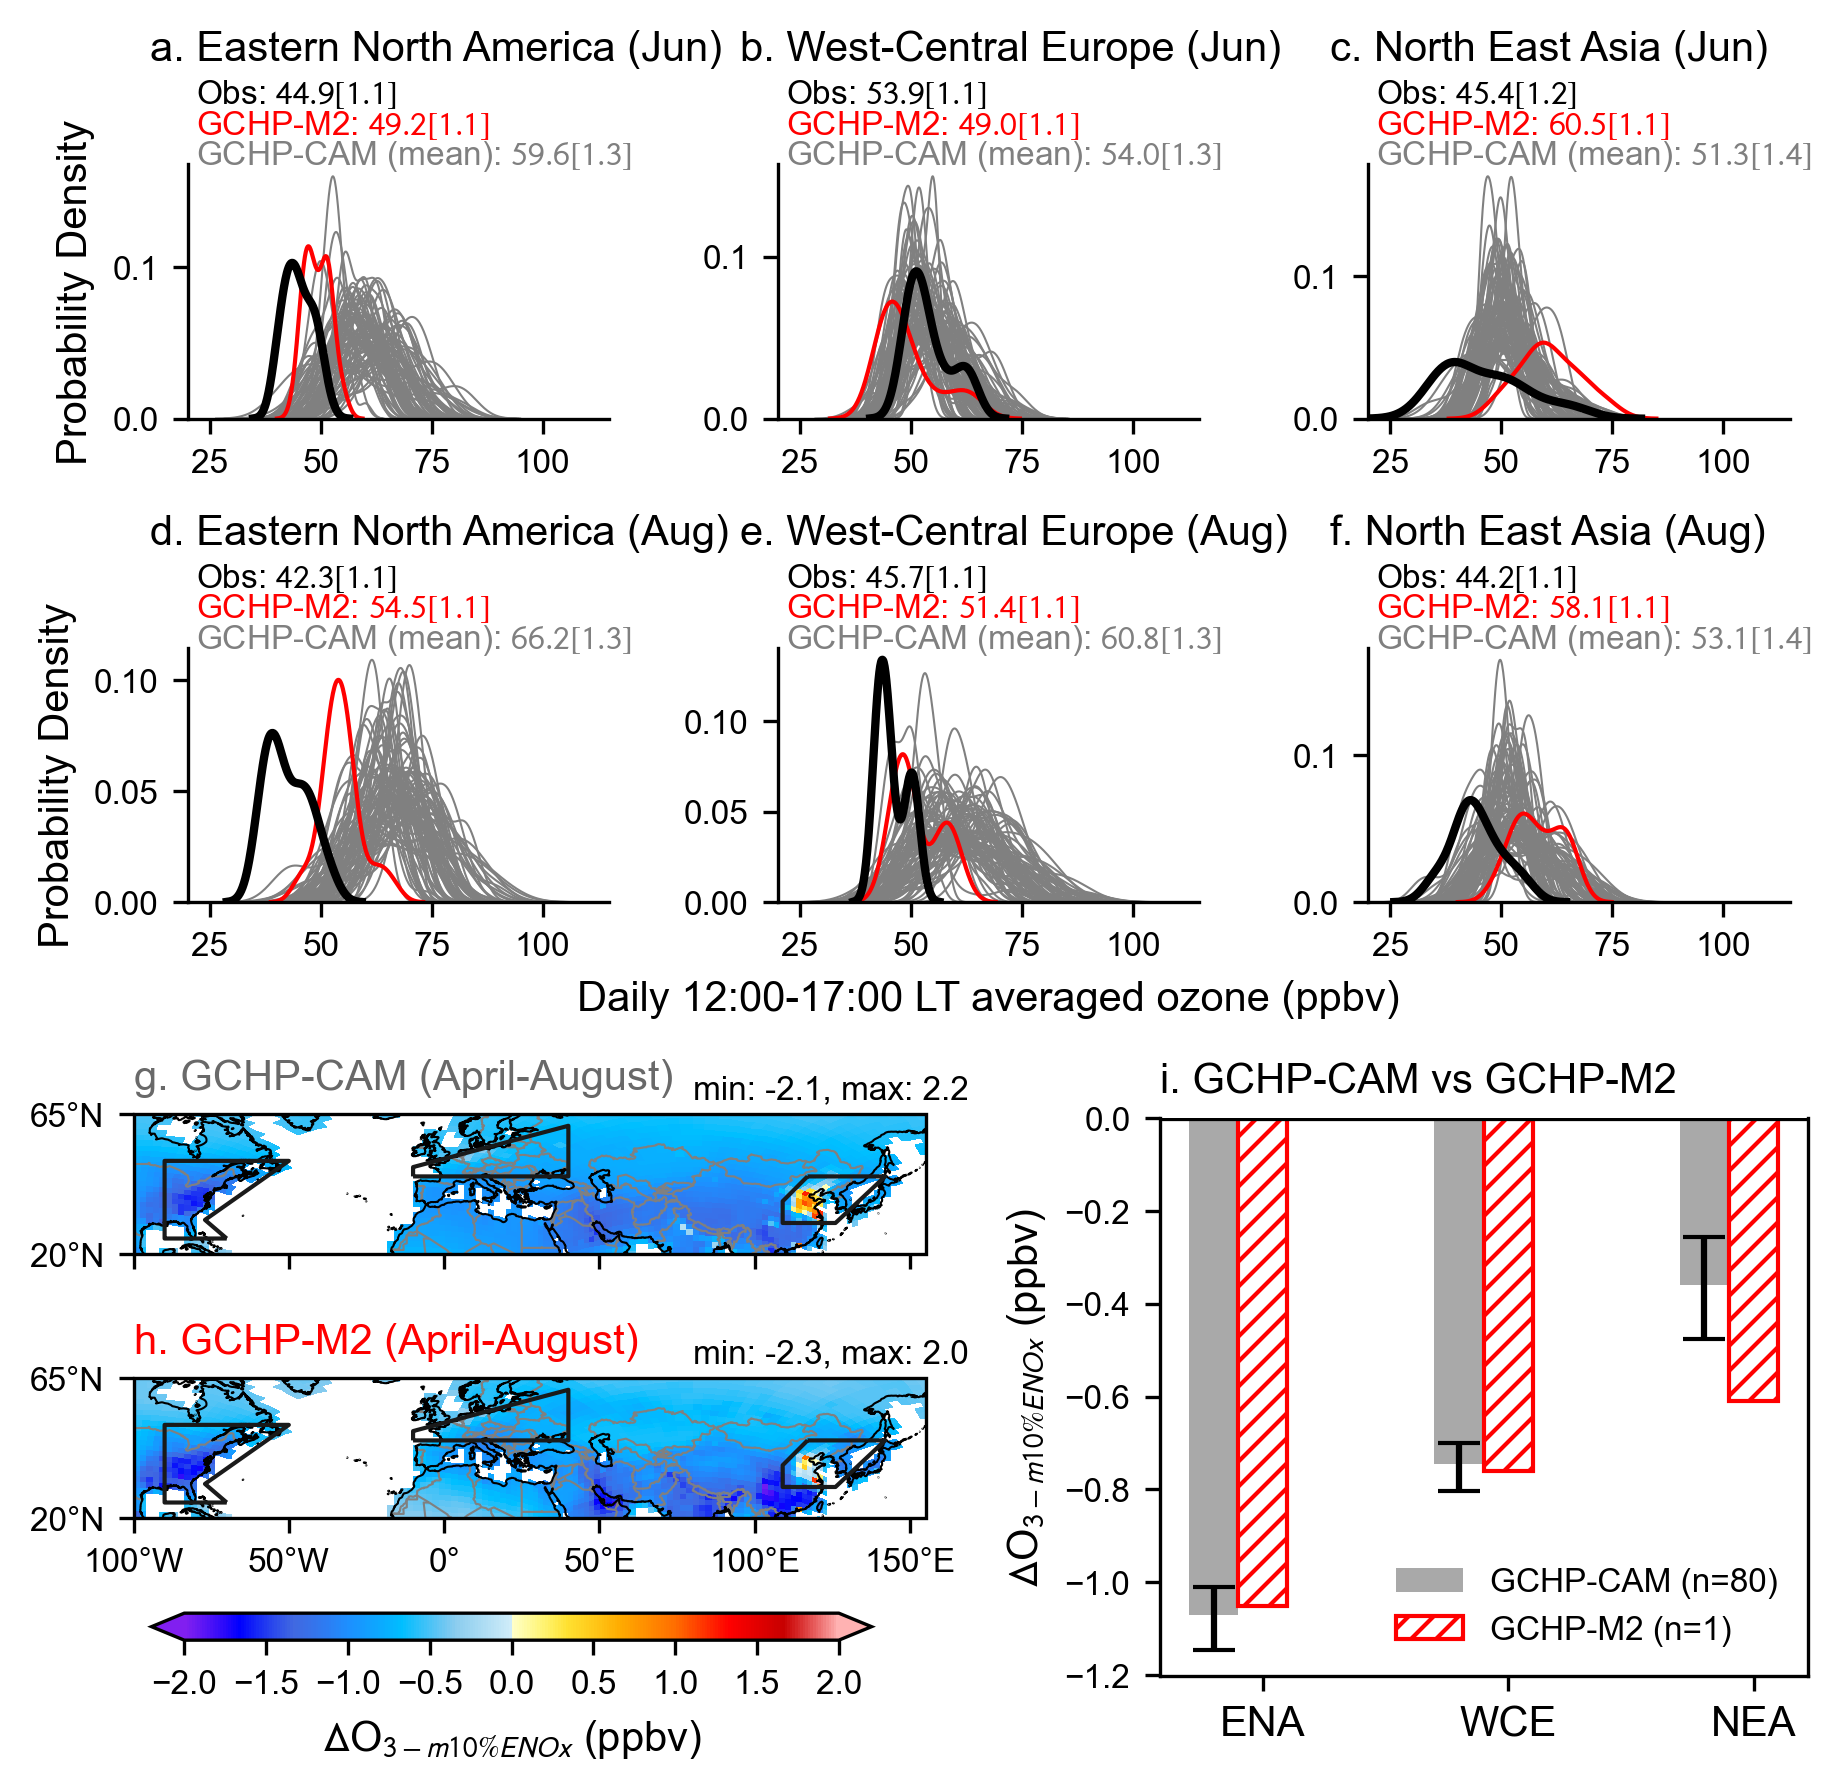

In [21]:
# Plot figure
tools.set_matplotlib_font("Arial")
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
    
color = 'black'

mpl.rcParams.update({
    'axes.edgecolor': color,      
    'xtick.color': color,         
    'ytick.color': color,         
    'xtick.labelcolor': color,    
    'ytick.labelcolor': color,    
    'grid.color': color,          
    'axes.labelcolor': color,    
    'axes.titlecolor': color,    
})

mpl.rcParams.update({
    'font.size': 8, 
    'axes.titlesize': 10, 
    'axes.labelsize': 10,
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8, 
    'legend.fontsize': 8,
    'figure.titlesize': 10
})

fig_width_in = 6
fig_height_in = 6

fig = plt.figure(figsize=(fig_width_in, fig_height_in), dpi=300)

gs1 = GridSpec(2, 3, top=0.90, bottom=0.49, left=0.09, right=0.98, hspace=0.9, wspace=0.4)
ax1 = fig.add_subplot(gs1[0, 0])
ax2 = fig.add_subplot(gs1[0, 1])
ax3 = fig.add_subplot(gs1[0, 2])
ax4 = fig.add_subplot(gs1[1, 0])
ax5 = fig.add_subplot(gs1[1, 1])
ax6 = fig.add_subplot(gs1[1, 2])

gs2 = GridSpec(2, 1, top=0.40, bottom=0.12, left=0.06, right=0.50, hspace = 0.10, wspace=0.05)
ax7 = fig.add_subplot(gs2[0, 0], projection=ccrs.PlateCarree(central_longitude=0))
ax8 = fig.add_subplot(gs2[1, 0], projection=ccrs.PlateCarree(central_longitude=0))

gs3 = GridSpec(1, 1, top=0.37, bottom=0.06, left=0.63, right=0.99, hspace = 0.30, wspace=0.05)
ax9 = fig.add_subplot(gs3[0, 0])

#################################################################################
# Part 1: Distributional Afternoon Ozone Evaluation: OBS vs GCHP-CAM vs GCHP-M2

ax = [ax1, ax2, ax3, ax4, ax5, ax6]

titles= [r"a. Eastern North America (Jun)", "b. West-Central Europe (Jun)", "c. North East Asia (Jun)",
         "d. Eastern North America (Aug)", "e. West-Central Europe (Aug)", "f. North East Asia (Aug)"]
observation_months = [6,6,6, 8,8,8]

GCHP_CAM_values = []
GCHP_M2_values = []

for idx, data in enumerate(all_observations):

    # Load OBS
    sitemean_mda8o3_ar6 = data.groupby("SITE_ID").mean()
    observation_mask = tools.get_observation_mask(sitemean_mda8o3_ar6)
    
    # Load GCHP-M2
    da_M2 = tools.get_masked_model_mda8o3(M2_for_observations, observation_mask, observation_months[idx])
    GCHP_M2_mean = da_M2.mean(dim=['nf', 'Ydim', 'Xdim'])
    GCHP_M2_values.append(GCHP_M2_mean)

    # Load GCHP-CAM
    da_CAM = tools.get_masked_model_mda8o3(CAM_for_observations, observation_mask, observation_months[idx])
    GCHP_CAM_mean = da_CAM.mean(dim=['nf', 'Ydim', 'Xdim'])
    
    ###################
    # GCHP-CAM for each ensemble member
    means_ref = []
    stds_ref = []
    for sim in range(5):
        GCHP_sim_ref = GCHP_CAM_mean.isel(sim=sim)
        for year in range(2000, 2016): 
            GCHP_year_ref = GCHP_sim_ref.sel(time=GCHP_sim_ref.time.dt.year == year)
            sns.distplot(GCHP_year_ref, ax=ax[idx], hist=False, kde=True, kde_kws={'linewidth': 0.5}, color="grey")
            GCHP_CAM_values.append(GCHP_year_ref)

            if np.isnan(GCHP_year_ref.mean().values.item()): # check for nans
                print(sim)
                print(year)
            else:
                means_ref.append(GCHP_year_ref.mean().values.item())
                stds_ref.append(GCHP_year_ref.std().values.item())

    #model_mean_ref = np.mean(means_ref)
    #model_std_ref = np.mean(stds_ref)
    #formatted_mmean_ref = format(model_mean_ref, ".1f")
    #formatted_mstdv_ref = format(model_std_ref, ".1f")

    # Extract geometric mean and geometric stdev
    model_geomean_ref = gmean(means_ref)    
    model_geostd_ref = gstd(stds_ref)
    formatted_geommean_ref = format(model_geomean_ref, ".1f")
    formatted_geomstdv_ref = format(model_geostd_ref, ".1f")

    # GCHP-CAM model text on panel
    mtext_ref = r'GCHP-CAM (mean): ' + rf'${formatted_geommean_ref} [{formatted_geomstdv_ref}]$'

    ###################
    # GCHP-M2
    sns.distplot(GCHP_M2_mean, ax=ax[idx], hist=False, kde=True, kde_kws={'linewidth': 1}, color="red")
    
    #model_mean = np.mean(GCHP_M2_mean.values)
    #model_std = np.std(GCHP_M2_mean.values)
    #formatted_mmean = format(model_mean, ".1f")
    #formatted_mstdv = format(model_std, ".1f")

    # Extract geometric mean and geometric stdev
    model_geomean = gmean(GCHP_M2_mean.values)
    model_geomstd = gstd(GCHP_M2_mean.values)
    formatted_mgeommean = format(model_geomean, ".1f")
    formatted_mgeomstdv = format(model_geomstd, ".1f")

    # GCHP-M2 model text on panel
    mtext = r'GCHP-M2: ' + rf'${formatted_mgeommean}  [{formatted_mgeomstdv}]$'

    ###################
    # OBSERVATIONS
    daily_mean = data.groupby(['DATE']).mean()['O3_mda8']
    sns.distplot(daily_mean, ax=ax[idx], hist=False, kde=True, kde_kws={'linewidth': 2}, color='k')

    #obs_mean = np.mean(daily_mean)
    #obs_std = np.std(daily_mean)
    #formatted_omean = format(obs_mean, ".1f")
    #formatted_ostdv = format(obs_std, ".1f")

    # Extract geometric mean and geometric stdev
    obs_geommean = gmean(daily_mean)
    obs_geomstd = gstd(daily_mean)
    formatted_ogeommean = format(obs_geommean, ".1f")
    formatted_ogeomstdv = format(obs_geomstd, ".1f")

    # Observations text on panel
    otext = r'Obs: ' + rf'${formatted_ogeommean}  [{formatted_ogeomstdv}]$'

    # Print titles + geomean/geostdev on each panel
    ax[idx].text(.02, 1.10, mtext_ref, ha='left', va='top', transform=ax[idx].transAxes, color='grey', fontsize=8)
    ax[idx].text(.02, 1.22, mtext, ha='left', va='top', transform=ax[idx].transAxes, color='red', fontsize=8)
    ax[idx].text(.02, 1.34, otext, ha='left', va='top', transform=ax[idx].transAxes, color='black', fontsize=8)
    ax[idx].text(-0.09, 1.53, titles[idx], ha='left', va='top', transform=ax[idx].transAxes, color='black', fontsize=10)

    # Format spines and axes
    ax[idx].spines[['right', 'top']].set_visible(False)
    ax[idx].set_xlim([20, 115])
    ax[idx].set_xlabel(None)
    ax[idx].set_ylabel(None)

# X-Label
xlabel = "Daily 12:00-17:00 LT averaged ozone (ppbv)"
ax5.set_xlabel(xlabel, fontsize=10)

# Y-Label
ylabel = "Probability Density"
ax1.set_ylabel(ylabel, fontsize=10)
ax4.set_ylabel(ylabel, fontsize=10)

#################################################################################
# Part 2: Spatial Ozone Response Comparison: GCHP-CAM vs GCHP-M2
ax = [ax7, ax8]
titles= ["g. GCHP-CAM (April-August)", "h. GCHP-M2 (April-August)"]
colors = ['dimgrey', 'red']
cmap = cmaps.ncl_default

# GCHP-CAM and GCHP-M2
CAM_response_seasonal = CAM_response.sel(time=CAM_response.time.dt.month.isin(comparison_months)).mean(dim=['time', 'sim'])
M2_response_seasonal = M2_response.sel(time=M2_response.time.dt.month.isin(comparison_months)).mean(dim=['time'])

for idx, z in enumerate([CAM_response_seasonal, M2_response_seasonal,]):
    plot = single_panel(plot_vals=z, 
                ax=ax[idx], gridtype="cs", 
                comap=cmap,
                extent=(-175, 175, 0, 75), 
                vmin=-2, vmax=2,
                unit="ppbv",
                title=None,
                add_cb=False,
                )
    # Map features
    country_borders = cfeature.NaturalEarthFeature(
        category="cultural",
        name="admin_0_boundary_lines_land",
        scale="50m",
        facecolor="none",
    )
    ax[idx].add_feature(country_borders, edgecolor="gray", linewidth=0.5)
    ax[idx].coastlines(color="black", linewidth=0.5)
    ax[idx].set_extent([-100, 155, 20, 65], crs=ccrs.PlateCarree())
    
    # X-tick labels
    ax[idx].set_xticks([-100, -50, 0, 50, 100, 150])
    ax[0].set_xticklabels(
            ['', '', '', '', '', ''], fontsize=6)
    ax[1].set_xticklabels(
            ['100°W', '50°W', '0°', '50°E', '100°E', '150°E'], fontsize=8)
    
    # Y-tick labels
    ax[idx].set_yticks([20,65])
    ax[0].set_yticklabels(
            ['20°N', '65°N'], fontsize=8)
    ax[1].set_yticklabels(
            ['20°N', '65°N'], fontsize=8)        

    # Add boxes around the IPCC AR6 regions
    ar6 = regionmask.defined_regions.ar6.all
    ar6[5,17].plot_regions( # ENA and WCE
        ax=ax[idx],
        add_label=False,
        line_kws=dict(lw=1),
    )
    # For NEA (aka "EAS") we use a modified polygon that captures a more homogeneous response
    new_EAS = np.array([[117,45], [109,37], [109,30], [126,30],[142,45]])
    new_EAS_region = regionmask.Regions([new_EAS], name="new_EAS")
    new_EAS_region.plot_regions(add_label=False, ax=ax[idx], line_kws=dict(lw=1))

    # Print titles and grid-box level min/max
    ax[idx].set_title(titles[idx], loc='left', size=10, color=colors[idx])
    ax[idx].annotate("min: "+"{:.1f}".format(z.min().values)+", max: "+"{:.1f}".format(z.max().values), (80,70), size=8)
    
# Colorbar
ticks = [-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
cbar_ax = fig.add_axes([0.07, 0.08, 0.4, 0.015])  # [left, bottom, width, height]
cbar = fig.colorbar(plot,  
                    cax=cbar_ax, 
                    ticks=ticks, 
                    orientation="horizontal", 
                    shrink=0.50, 
                    label=r"$\Delta$O$_{3-m10\%ENOx}$ (ppbv)",
                    extend='both'
                    )
cbar.ax.tick_params(labelsize=8)

#################################################################################
## Part 3: Regional mean barplots ozone response: CAM vs M2 ##
ax = [ax9]

bar_width = 0.15
categories = ['ENA', 'WCE', 'NEA']
x = 0.75*np.arange(len(categories))

# GCHP-CAM vs GCHP-M2
ax[0].bar(x - bar_width, ref_mean,   bar_width, yerr=tools.reshape_data(ref_std),      capsize=5, label="GCHP-CAM (n=80)", color="darkgray")
ax[0].bar(x,             refM2_mean, bar_width, label="GCHP-M2 (n=1)", color="white", hatch='////', edgecolor="red")

# Barplot features
ax[0].set_title("i. GCHP-CAM vs GCHP-M2", loc='left', fontsize=10)
ax[0].set_ylabel(r"$\Delta$O$_{3-m10\%ENOx}$ (ppbv)", fontsize=10)
ax[0].set_xticks(x, categories, fontsize=10)
ax[0].spines[['top']].set_visible(False)
ax[0].axhline(0, color='k')
ax[0].legend(fontsize=8, frameon=False)

#################################################################################
plt.savefig("Fig1_new.pdf")

In [22]:
# Print ensemble-mean values of the historical ozone response (reported in Section 3.2)

CAM_response_seasonal = CAM_response.sel(time=CAM_response.time.dt.month.isin(comparison_months)).mean(dim=['time', 'sim'])

ref_ENA = tools.crop_regionmask_ar6_c48(CAM_response_seasonal, region_num=5)
ref_WCE = tools.crop_regionmask_ar6_c48(CAM_response_seasonal, region_num=17)
ref_NEA = tools.crop_regionmask_ar6_c48(CAM_response_seasonal, region_num=58)

In [23]:
print(ref_ENA.mean()) # regional-mean
print(ref_ENA.max())  # gridbox-max
print(ref_ENA.min())  # gridbox-min

print(ref_WCE.mean())
print(ref_WCE.max())
print(ref_WCE.min())

print(ref_NEA.mean())
print(ref_NEA.max())
print(ref_NEA.min())

<xarray.DataArray 'SpeciesConc_O3' ()>
array(-1.07093497)
<xarray.DataArray 'SpeciesConc_O3' ()>
array(-0.40558671)
<xarray.DataArray 'SpeciesConc_O3' ()>
array(-1.62158671)
<xarray.DataArray 'SpeciesConc_O3' ()>
array(-0.74596307)
<xarray.DataArray 'SpeciesConc_O3' ()>
array(-0.31432309)
<xarray.DataArray 'SpeciesConc_O3' ()>
array(-0.95363446)
<xarray.DataArray 'SpeciesConc_O3' ()>
array(-0.36065968)
<xarray.DataArray 'SpeciesConc_O3' ()>
array(2.18692319)
<xarray.DataArray 'SpeciesConc_O3' ()>
array(-1.22475333)


In [24]:
# Shapiro-Wilk Test for Normality/Log-Normality (to justify use of geomean/geostdev)

p_normals = []
p_log_normals = []
for idx in range(6):
    data = GCHP_M2_values[idx]
    # Shapiro-Wilk Test for normality
    stat_normal, p_normal = stats.shapiro(data)
    p_normals.append(p_normal)
    print(f"Shapiro-Wilk Test for Normality: Statistic={stat_normal}, p-value={p_normal}")

    # Log-transform and test for log-normality
    log_data = np.log(data - np.min(data) + 1)  # Adjusting data for log transformation
    stat_log_normal, p_log_normal = stats.shapiro(log_data)
    p_log_normals.append(p_log_normal)
    print(f"Shapiro-Wilk Test for Log-Normality: Statistic={stat_log_normal}, p-value={p_log_normal}")


Shapiro-Wilk Test for Normality: Statistic=0.9593297839164734, p-value=0.29776281118392944
Shapiro-Wilk Test for Log-Normality: Statistic=0.9326416850090027, p-value=0.05773552507162094
Shapiro-Wilk Test for Normality: Statistic=0.8313921689987183, p-value=0.00025897190789692104
Shapiro-Wilk Test for Log-Normality: Statistic=0.9636804461479187, p-value=0.3832695484161377
Shapiro-Wilk Test for Normality: Statistic=0.976253092288971, p-value=0.7196065783500671
Shapiro-Wilk Test for Log-Normality: Statistic=0.8595941066741943, p-value=0.0009912877576425672
Shapiro-Wilk Test for Normality: Statistic=0.940811276435852, p-value=0.08689489215612411
Shapiro-Wilk Test for Log-Normality: Statistic=0.800666868686676, p-value=5.310524647939019e-05
Shapiro-Wilk Test for Normality: Statistic=0.8721275329589844, p-value=0.0015576177975162864
Shapiro-Wilk Test for Log-Normality: Statistic=0.9318761825561523, p-value=0.049325279891490936
Shapiro-Wilk Test for Normality: Statistic=0.950137197971344, p-v